## Compare AKTERM outputs
Load our generated AKTERM file and the reference `akzr_muenchen_stadt_05_z0.akt` and compare per timestamp: wind speed (0.1 m/s), wind direction (deg), and Kennzahl.

In [57]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = Path(r'U:\Abt02\Ref23\Daten\LQ-Modellierung\06_Modellierung\04_WINMiskam\02_Meteorologie')
YEAR = 2009
OUR_PATH = BASE_DIR / 'data' / 'processed' / f'akterm_{YEAR}_muenchen_stadt.akt'
REF_PATH = Path(r'U:\Abt02\Ref23\Daten\LQ-Modellierung\06_Modellierung\04_WINMiskam\02_Meteorologie\data\raw\wind\akterm_muenchen_stadt_09.aks')
OUR_PATH, REF_PATH


(WindowsPath('U:/Abt02/Ref23/Daten/LQ-Modellierung/06_Modellierung/04_WINMiskam/02_Meteorologie/data/processed/akterm_2009_muenchen_stadt.akt'),
 WindowsPath('U:/Abt02/Ref23/Daten/LQ-Modellierung/06_Modellierung/04_WINMiskam/02_Meteorologie/data/raw/wind/akterm_muenchen_stadt_09.aks'))

In [58]:
def _as_int(val):
    try:
        return int(val)
    except Exception:
        return None


def _load_our(path: Path) -> pd.DataFrame:
    rows = []
    with path.open(encoding='latin1') as f:
        for line in f:
            if line.startswith('*') or line.startswith('+') or not line.strip():
                continue
            parts = line.split()
            if len(parts) < 11:
                continue
            year, month, day, hour, minute = map(int, parts[2:7])
            wdir = _as_int(parts[7])
            ws_01ms = _as_int(parts[8])
            ak = parts[9] if parts[9] else None
            main_ak = parts[10] if len(parts) > 10 else None
            ts = pd.Timestamp(year=year, month=month, day=day, hour=hour, minute=minute, tz='UTC')
            rows.append({'timestamp': ts, 'wind_dir_deg': wdir, 'wind_speed_01ms': ws_01ms, 'kennzahl': main_ak, 'ak_raw': ak})
    return pd.DataFrame(rows)


def _load_ref(path: Path) -> pd.DataFrame:
    rows = []
    with path.open(encoding='latin1') as f:
        for line in f:
            if line.startswith('*') or line.startswith('+') or not line.strip():
                continue
            parts = line.split()
            if len(parts) < 13:
                continue
            year, month, day, hour, minute = map(int, parts[2:7])
            # AKTERM 2009 layout: two flag columns, then wdir/ws (idx9/idx10), raw ak (idx11), kennzahl (idx12)
            wdir = _as_int(parts[9])
            ws_01ms = _as_int(parts[10])
            ak = parts[11] if parts[11] else None
            main_ak = parts[12] if len(parts) > 12 and parts[12] else None
            ts = pd.Timestamp(year=year, month=month, day=day, hour=hour, minute=minute, tz='UTC')
            rows.append({'timestamp': ts, 'wind_dir_deg': wdir, 'wind_speed_01ms': ws_01ms, 'kennzahl': main_ak, 'ak_raw': ak})
    df = pd.DataFrame(rows)
    df['wind_dir_deg'] = pd.to_numeric(df['wind_dir_deg'], errors='coerce').astype('Int64')
    df['wind_speed_01ms'] = pd.to_numeric(df['wind_speed_01ms'], errors='coerce').astype('Int64')
    return df


def _prep(df: pd.DataFrame) -> pd.DataFrame:
    out = df[['timestamp', 'wind_dir_deg', 'wind_speed_01ms', 'kennzahl']].copy()
    out['timestamp'] = pd.to_datetime(out['timestamp'], utc=True)
    out['wind_dir_deg'] = pd.to_numeric(out['wind_dir_deg'], errors='coerce').astype('Int64')
    out['wind_speed_01ms'] = pd.to_numeric(out['wind_speed_01ms'], errors='coerce').astype('Int64')
    return out.sort_values('timestamp').reset_index(drop=True)


def _load_clouds(base_dir: Path) -> pd.DataFrame:
    """Load cloud cover and align timestamps to UTC to match AKTERM exports."""
    cloud_path = base_dir / 'data' / 'processed' / f'merged_wind_cloud_{YEAR}_day_night.csv'
    cdf = pd.read_csv(cloud_path, usecols=['timestamp_local', 'cloud_cover_oktas'])
    # Timestamp strings already include offset (+01:00/+02:00); parse directly to UTC tz-aware
    ts_utc = pd.to_datetime(cdf['timestamp_local'], errors='coerce', utc=True)
    cdf['timestamp'] = ts_utc
    return cdf[['timestamp', 'cloud_cover_oktas']]


# Prepare series (no time shift)
our_df = _prep(_load_our(OUR_PATH))
ref_df = _prep(_load_ref(REF_PATH))
cloud_df = _load_clouds(BASE_DIR)

our_df.head(), ref_df.head()



(                  timestamp  wind_dir_deg  wind_speed_01ms kennzahl
 0 2009-01-01 00:00:00+00:00           280               15        1
 1 2009-01-01 01:00:00+00:00           250               16        1
 2 2009-01-01 02:00:00+00:00           240               20        1
 3 2009-01-01 03:00:00+00:00           250               17        1
 4 2009-01-01 04:00:00+00:00           230               19        1,
                   timestamp  wind_dir_deg  wind_speed_01ms kennzahl
 0 2009-01-01 00:00:00+00:00           280               15        1
 1 2009-01-01 01:00:00+00:00           250               16        1
 2 2009-01-01 02:00:00+00:00           240               20        1
 3 2009-01-01 03:00:00+00:00           250               17        2
 4 2009-01-01 04:00:00+00:00           230               19        2)

In [59]:
merged = our_df.merge(ref_df, on='timestamp', how='outer', suffixes=('_our', '_ref'))
merged = merged.merge(cloud_df.rename(columns={'cloud_cover_oktas': 'cloud_cover_oktas_our'}), on='timestamp', how='left')
merged['wind_dir_match'] = merged['wind_dir_deg_our'].eq(merged['wind_dir_deg_ref'])
merged['wind_speed_match'] = merged['wind_speed_01ms_our'].eq(merged['wind_speed_01ms_ref'])
merged['kennzahl_match'] = merged['kennzahl_our'].eq(merged['kennzahl_ref'])
merged['all_match'] = merged[['wind_dir_match', 'wind_speed_match', 'kennzahl_match']].all(axis=1)

merged[['timestamp', 'wind_dir_deg_our', 'wind_dir_deg_ref', 'wind_speed_01ms_our', 'wind_speed_01ms_ref', 'kennzahl_our', 'kennzahl_ref', 'cloud_cover_oktas_our', 'all_match']].head()

# Count total matches
total_rows = len(merged)
match_rows = merged['all_match'].sum()
print(f"matching rows: {match_rows} / {total_rows} ({match_rows/total_rows:.1%})")



matching rows: 7353 / 8760 (83.9%)


,timestamp,wind_dir_deg_our,wind_dir_deg_ref,wind_speed_01ms_our,wind_speed_01ms_ref,kennzahl_our,kennzahl_ref,cloud_cover_oktas_our
3,2009-01-01 03:00:00+00:00,250,250,17,17,1,2,NaN
4,2009-01-01 04:00:00+00:00,230,230,19,19,1,2,NaN
8,2009-01-01 08:00:00+00:00,340,340,18,18,3,2,8.0
16,2009-01-01 16:00:00+00:00,360,350,14,14,2,2,8.0
18,2009-01-01 18:00:00+00:00,10,10,14,14,1,7,-1.0
19,2009-01-01 19:00:00+00:00,40,40,10,10,1,7,-1.0
21,2009-01-01 21:00:00+00:00,360,360,8,8,1,2,NaN
22,2009-01-01 22:00:00+00:00,10,10,9,9,1,2,NaN
23,2009-01-01 23:00:00+00:00,50,50,11,11,1,2,NaN
25,2009-01-02 01:00:00+00:00,50,50,21,21,1,2,NaN


C:\Users\LFU-mayer_t2\AppData\Local\Temp\ipykernel_20116\2828658295.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(delta_box_data, labels=cats, showfliers=True)


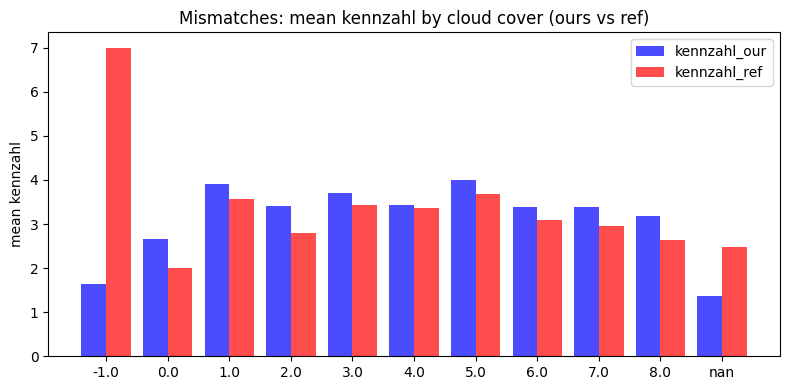

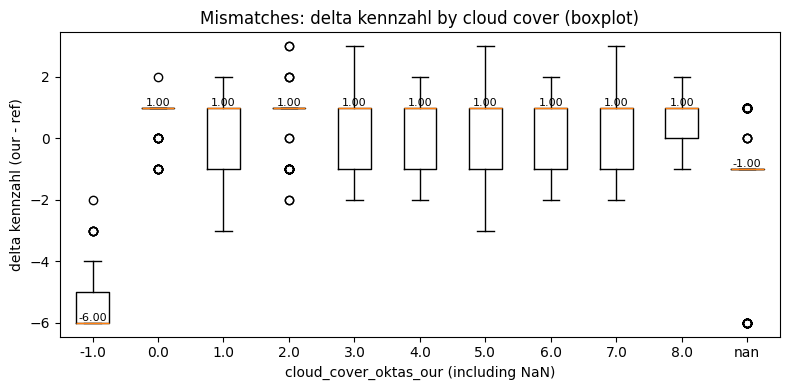

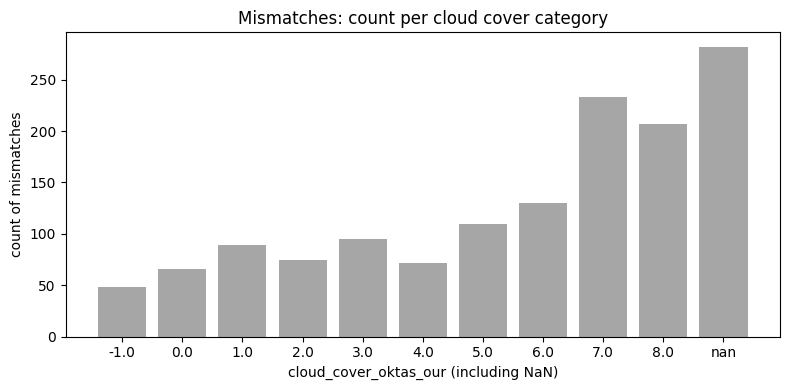

In [60]:
# Rows with any mismatch
mismatches = merged.loc[~merged['all_match']].copy()
mismatches[['timestamp', 'wind_dir_deg_our', 'wind_dir_deg_ref', 'wind_speed_01ms_our', 'wind_speed_01ms_ref', 'kennzahl_our', 'kennzahl_ref', 'cloud_cover_oktas_our']].head(50)
display(mismatches[['timestamp', 'wind_dir_deg_our', 'wind_dir_deg_ref', 'wind_speed_01ms_our', 'wind_speed_01ms_ref', 'kennzahl_our', 'kennzahl_ref', 'cloud_cover_oktas_our']].head(50))


# Bar plot: mean kennzahl by cloud cover (mismatches only), bars side-by-side
plot_df = mismatches.copy()
plot_df['kennzahl_our'] = pd.to_numeric(plot_df['kennzahl_our'], errors='coerce')
plot_df['kennzahl_ref'] = pd.to_numeric(plot_df['kennzahl_ref'], errors='coerce')
plot_df['cloud_cat'] = plot_df['cloud_cover_oktas_our'].astype(str)
grp = plot_df.groupby('cloud_cat').agg({
    'kennzahl_our': 'mean',
    'kennzahl_ref': 'mean'
}).reset_index()
x = range(len(grp))
width = 0.4
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([i - width/2 for i in x], grp['kennzahl_our'], width=width, color='blue', alpha=0.7, label='kennzahl_our')
ax.bar([i + width/2 for i in x], grp['kennzahl_ref'], width=width, color='red', alpha=0.7, label='kennzahl_ref')
ax.set_xticks(list(x))
ax.set_xticklabels(grp['cloud_cat'])
ax.set_ylabel('mean kennzahl')
ax.set_title('Mismatches: mean kennzahl by cloud cover (ours vs ref)')
ax.legend()
plt.tight_layout()

# Boxplot of delta (kennzahl_our - kennzahl_ref) per cloud cover category
plot_df['delta'] = plot_df['kennzahl_our'] - plot_df['kennzahl_ref']
cats = sorted(plot_df['cloud_cat'].unique())
delta_box_data = [plot_df.loc[plot_df['cloud_cat']==c, 'delta'].dropna() for c in cats]
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(delta_box_data, labels=cats, showfliers=True)
medians = [series.median() for series in delta_box_data]
for i, med in enumerate(medians, start=1):
    if pd.notna(med):
        ax.text(i, med, f'{med:.2f}', ha='center', va='bottom', fontsize=8, color='black')
ax.set_xlabel('cloud_cover_oktas_our (including NaN)')
ax.set_ylabel('delta kennzahl (our - ref)')
ax.set_title('Mismatches: delta kennzahl by cloud cover (boxplot)')
plt.tight_layout()

# Bar plot: count of mismatches per cloud cover category
mismatch_counts = plot_df.groupby('cloud_cat').size().reindex(cats, fill_value=0)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(len(cats)), mismatch_counts.values, color='gray', alpha=0.7)
ax.set_xticks(list(range(len(cats))))
ax.set_xticklabels(cats)
ax.set_xlabel('cloud_cover_oktas_our (including NaN)')
ax.set_ylabel('count of mismatches')
ax.set_title('Mismatches: count per cloud cover category')
plt.tight_layout()


In [61]:
# Compare raw wind (03379_Muenchen_stadt.txt) vs AKTERM 2009
if '_load_raw_wind' not in globals():
    def _load_raw_wind(path: Path) -> pd.DataFrame:
        df = pd.read_csv(path, sep=';', comment='#', skipinitialspace=True)
        df.columns = [c.strip() for c in df.columns]
        df['timestamp'] = pd.to_datetime(df['MESS_DATUM'].astype(str), format='%Y%m%d%H', errors='coerce', utc=True)
        df['wind_speed_ms'] = pd.to_numeric(df['F'].astype(str).str.replace(',', '.'), errors='coerce')
        df['wind_dir_deg'] = pd.to_numeric(df['D'], errors='coerce')
        df['wind_speed_01ms'] = pd.to_numeric((df['wind_speed_ms'] * 10).round(), errors='coerce').astype('Int64')
        return df[['timestamp', 'wind_dir_deg', 'wind_speed_01ms']]
RAW_WIND_PATH = BASE_DIR / 'data' / 'raw' / 'wind' / '03379_Muenchen_stadt.txt'
raw_wind_df = _load_raw_wind(RAW_WIND_PATH)

raw_ref_merge = raw_wind_df.merge(
    ref_df[['timestamp', 'wind_dir_deg', 'wind_speed_01ms']].rename(columns={
        'wind_dir_deg': 'wind_dir_deg_ref',
        'wind_speed_01ms': 'wind_speed_01ms_ref'
    }),
    on='timestamp',
    how='inner'
)
raw_ref_merge['wind_dir_deg'] = pd.to_numeric(raw_ref_merge['wind_dir_deg'], errors='coerce').astype('Int64')
raw_ref_merge['wind_dir_deg_ref'] = pd.to_numeric(raw_ref_merge['wind_dir_deg_ref'], errors='coerce').astype('Int64')
raw_ref_merge['wind_speed_01ms'] = pd.to_numeric(raw_ref_merge['wind_speed_01ms'], errors='coerce').astype('Int64')
raw_ref_merge['wind_speed_01ms_ref'] = pd.to_numeric(raw_ref_merge['wind_speed_01ms_ref'], errors='coerce').astype('Int64')
raw_ref_merge['wind_dir_match'] = raw_ref_merge['wind_dir_deg'].eq(raw_ref_merge['wind_dir_deg_ref'])
raw_ref_merge['wind_speed_match'] = raw_ref_merge['wind_speed_01ms'].eq(raw_ref_merge['wind_speed_01ms_ref'])
raw_ref_merge['all_match'] = raw_ref_merge[['wind_dir_match', 'wind_speed_match']].all(axis=1)

print(f"raw vs AKTERM matching rows: {raw_ref_merge['all_match'].sum()} / {len(raw_ref_merge)}")
mismatches = raw_ref_merge.loc[~raw_ref_merge['all_match'], ['timestamp', 'wind_dir_deg', 'wind_dir_deg_ref', 'wind_speed_01ms', 'wind_speed_01ms_ref', 'all_match']]
mismatches.head(50)


raw vs AKTERM matching rows: 8713 / 8760


,timestamp,wind_dir_deg,wind_dir_deg_ref,wind_speed_01ms,wind_speed_01ms_ref,all_match
16,2009-01-01 16:00:00+00:00,360,350,14,14,False
41,2009-01-02 17:00:00+00:00,360,350,13,13,False
111,2009-01-05 15:00:00+00:00,360,10,15,15,False
157,2009-01-07 13:00:00+00:00,10,20,11,11,False
162,2009-01-07 18:00:00+00:00,360,350,12,12,False
232,2009-01-10 16:00:00+00:00,20,30,16,16,False
256,2009-01-11 16:00:00+00:00,360,10,13,13,False
276,2009-01-12 12:00:00+00:00,10,20,9,9,False
288,2009-01-13 00:00:00+00:00,80,90,6,6,False
295,2009-01-13 07:00:00+00:00,40,50,14,14,False


In [62]:
# Compare raw wind vs our AKTERM export (akterm_2009_muenchen_stadt.akt)
raw_wind_df = _load_raw_wind(RAW_WIND_PATH)
our_unshifted = _prep(_load_our(OUR_PATH))

raw_our_merge = raw_wind_df.merge(
    our_unshifted[['timestamp', 'wind_dir_deg', 'wind_speed_01ms']].rename(columns={
        'wind_dir_deg': 'wind_dir_deg_our',
        'wind_speed_01ms': 'wind_speed_01ms_our'
    }),
    on='timestamp',
    how='inner'
)
raw_our_merge['wind_dir_deg'] = pd.to_numeric(raw_our_merge['wind_dir_deg'], errors='coerce').astype('Int64')
raw_our_merge['wind_dir_deg_our'] = pd.to_numeric(raw_our_merge['wind_dir_deg_our'], errors='coerce').astype('Int64')
raw_our_merge['wind_speed_01ms'] = pd.to_numeric(raw_our_merge['wind_speed_01ms'], errors='coerce').astype('Int64')
raw_our_merge['wind_speed_01ms_our'] = pd.to_numeric(raw_our_merge['wind_speed_01ms_our'], errors='coerce').astype('Int64')

raw_our_merge['wind_dir_match'] = raw_our_merge['wind_dir_deg'].eq(raw_our_merge['wind_dir_deg_our'])
raw_our_merge['wind_speed_match'] = raw_our_merge['wind_speed_01ms'].eq(raw_our_merge['wind_speed_01ms_our'])
raw_our_merge['all_match'] = raw_our_merge[['wind_dir_match', 'wind_speed_match']].all(axis=1)

print(f"raw vs OUR matching rows: {raw_our_merge['all_match'].sum()} / {len(raw_our_merge)}")
raw_our_merge[['timestamp', 'wind_dir_deg', 'wind_dir_deg_our', 'wind_speed_01ms', 'wind_speed_01ms_our', 'all_match']].head(20)


raw vs OUR matching rows: 8760 / 8760


,timestamp,wind_dir_deg,wind_dir_deg_our,wind_speed_01ms,wind_speed_01ms_our,all_match
0,2009-01-01 00:00:00+00:00,280,280,15,15,True
1,2009-01-01 01:00:00+00:00,250,250,16,16,True
2,2009-01-01 02:00:00+00:00,240,240,20,20,True
3,2009-01-01 03:00:00+00:00,250,250,17,17,True
4,2009-01-01 04:00:00+00:00,230,230,19,19,True
5,2009-01-01 05:00:00+00:00,260,260,14,14,True
6,2009-01-01 06:00:00+00:00,270,270,13,13,True
7,2009-01-01 07:00:00+00:00,270,270,18,18,True
8,2009-01-01 08:00:00+00:00,340,340,18,18,True
9,2009-01-01 09:00:00+00:00,350,350,15,15,True
